<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a3_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:37

# Student 1: Peter Elmers | 1734350

# Student 2: P.T.C.M. Tholhuijsen | 1237447

# Student 3: Jiong Li | 1533312


# Downloading Data and Preliminaries

In [64]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [65]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [66]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [67]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [68]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [69]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

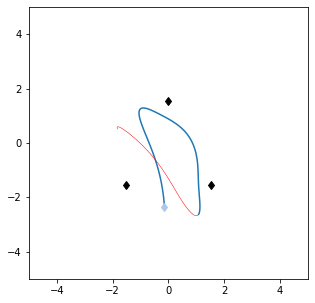

Charges are [-0.90690245 -0.56774982 -0.45512163]


In [70]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

# Task 3.1

## Data Handling and Preprocessing

In [71]:
# Pick the best device
import torch

def try_device(device):
    # Try to put an array on given device. If successful, return device. Else, 'cpu'.
    x = torch.ones((1,))
    try:
        x.to(device)
        return device
    except:
        return 'cpu'

device = try_device('cuda')
if device == 'cpu':
    # mps doesn't support our model (yet?)
    # device = try_device('mps')
    pass


print(f'Device is set to {device}')

Device is set to cpu


In [72]:
# Task 3.1: Using the positions of positively charged particle p1 during a simulation, predict the
# values of negative charges c2, c3, c4
# input = t locations (x, y) of p1 particle, value of t is not fixed

from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pack_sequence, pad_sequence

class SimulationData(Dataset):
    def __init__(self, sim, charges):
        self.sim = sim
        self.charges = charges

    def __len__(self):
        return len(self.sim)

    def __getitem__(self, idx):
        return self.sim[idx], self.charges[idx]

# Create data loader
def collate(data):
    # Sort data in order of decreasing sequence length
    data = list(reversed(sorted(data, key=lambda d: len(d[0]))))
    xs = pad_sequence([torch.tensor(x).float() for x, _ in data], batch_first=True)
    ys = torch.stack([torch.tensor(y).float() for _, y in data])
    return xs, ys

# Batch size needs to evenly divide all train, valid, test sizes (800, 100, 100)
batch_size = 5
train_dl = DataLoader(SimulationData(simulation_train, charges_train), batch_size=batch_size, shuffle=True, collate_fn=collate)
valid_dl = DataLoader(SimulationData(simulation_valid, charges_valid), batch_size=batch_size, shuffle=True, collate_fn=collate)


In [73]:
print(simulation_train[0].shape)
# Test data loader
xs, ys = next(iter(train_dl))
print(len(xs))
print(xs[0].shape, ys[0].shape)

(103, 2)
5
torch.Size([104, 2]) torch.Size([3])


In [74]:
# Baseline model: predict the mean value of each charge in the training set
baseline_values = torch.tensor(np.array(charges_train).mean(axis=0))
def baseline_predict(xs):
    batch = xs.shape[0]
    return baseline_values.expand(batch, 3)

loss_fn = lambda y, y_pred: (y - y_pred).abs().sum()

# Baseline error?

def avg_err(model, dl, loss_fn=torch.nn.L1Loss(reduction='sum')):
    with torch.no_grad():
        loss = 0
        n_samples = 0
        for x, y in dl:
            y_pred = model(x)
            loss += loss_fn(y, y_pred)
            n_samples += x.shape[0]
        return (loss / n_samples).item()


print(f'Baseline L1 train error: {avg_err(baseline_predict, train_dl)}')
print(f'Baseline L1 validation error: {avg_err(baseline_predict, valid_dl)}')

Baseline L1 train error: 0.7429319024085999
Baseline L1 validation error: 0.7968491315841675


## Model Implementation

In [75]:
class Model_3_1(torch.nn.Module):
    def __init__(self, hidden_dim, n_layers, batch_size, rnn='gru'):
        super(Model_3_1, self).__init__()
        # input/output size are fixed based on the task description
        input_dim = 2
        output_dim = 3

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.batch_size = batch_size
        self.is_lstm = rnn == 'lstm'
        
        if rnn == 'gru':
            self.rnn = torch.nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True)
        elif rnn == 'rnn':
            self.rnn = torch.nn.RNN(input_dim, hidden_dim, n_layers, batch_first=True)
        elif rnn == 'lstm':
            self.rnn = torch.nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.relu = torch.nn.ReLU()
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        if self.is_lstm:
            h = self.init_hidden()
            c = self.init_hidden()
            out, (h, c) = self.rnn(x, (h, c))
        else:
            h = self.init_hidden()
            out, h = self.rnn(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out
    
    def init_hidden(self):
        # from example of https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
        h0 = torch.zeros(self.n_layers, self.batch_size, self.hidden_dim).to(device)
        return h0

xs = xs.to(device)
model_3_1 = Model_3_1(30, 5, batch_size).to(device)
print(model_3_1(xs).shape)

torch.Size([5, 3])


## Model Training

In [76]:
from tqdm import tqdm

def fit_3_1(model, train_dl, valid_dl, n_epochs):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    loss_func = torch.nn.L1Loss()
    train_history = []
    valid_history = []
    best_state_dict = model.state_dict().copy()

    for i in tqdm(range(n_epochs)):
        model = model.train()
        for x, y in train_dl:
            x = x.to(device=device)
            y = y.to(device=device)
            y_pred = model(x)
            loss = loss_func(y, y_pred)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        model = model.eval()
        with torch.no_grad():
            train_err = avg_err(model, train_dl)
            val_err = avg_err(model, valid_dl)
            train_history.append(train_err)
            valid_history.append(val_err)
            if val_err == min(valid_history):
                best_state_dict = model.state_dict().copy()

    return {
        'train': train_history,
        'valid': valid_history,
        'best_state': best_state_dict,
    }

In [77]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n_layers = 1
epochs = 150
results = {}
for hidden_size in [32, 64, 128, 256]:
    model_3_1 = Model_3_1(hidden_size, n_layers, batch_size).to(device)
    print(f'Model has {count_parameters(model_3_1)} parameters w/ hidden size {hidden_size}')
    results[hidden_size] = fit_3_1(model_3_1, train_dl, valid_dl, epochs)
    print(f'Lowest training error was {min(results[hidden_size]["train"])}')
    print(f'Lowest validation error was {min(results[hidden_size]["valid"])}')

Model has 3555 parameters w/ hidden size 32


100%|██████████| 150/150 [04:45<00:00,  1.90s/it]


Lowest validation error was 0.14560025930404663
Model has 13251 parameters w/ hidden size 64


100%|██████████| 150/150 [05:18<00:00,  2.13s/it]


Lowest validation error was 0.1405370831489563
Model has 51075 parameters w/ hidden size 128


100%|██████████| 150/150 [08:09<00:00,  3.26s/it]


Lowest validation error was 0.13095705211162567
Model has 200451 parameters w/ hidden size 256


100%|██████████| 150/150 [15:37<00:00,  6.25s/it]

Lowest validation error was 0.13024581968784332


In [99]:
# Pick the best hidden size
# Chosen by looking at validation and training losses
hidden_size = 128
result = results[hidden_size]

In [100]:
# How much is GRU better?
model_3_1_rnn = Model_3_1(hidden_size, n_layers, batch_size, rnn='rnn').to(device)
print(f'RNN model has {count_parameters(model_3_1_rnn)} parameters w/ hidden size {hidden_size}')
result_rnn = fit_3_1(model_3_1_rnn, train_dl, valid_dl, epochs)
print(f'Lowest validation error was {min(result_rnn["valid"])}')
print(f'Lowest train error was {min(result_rnn["train"])}')

RNN model has 17283 parameters w/ hidden size 128


100%|██████████| 150/150 [02:38<00:00,  1.06s/it]

Lowest validation error was 0.7334606051445007
Lowest train error was 0.7005348205566406


In [101]:
# How about LSTM?
model_3_1_lstm = Model_3_1(hidden_size, n_layers, batch_size, rnn='lstm').to(device)
print(f'LSTM model has {count_parameters(model_3_1_lstm)} parameters w/ hidden size {hidden_size}')
result_lstm = fit_3_1(model_3_1_lstm, train_dl, valid_dl, epochs)
print(f'Lowest validation error was {min(result_lstm["valid"])}')
print(f'Lowest train error was {min(result_lstm["train"])}')

LSTM model has 67971 parameters w/ hidden size 128


100%|██████████| 150/150 [09:08<00:00,  3.66s/it]

Lowest validation error was 0.1589513123035431
Lowest train error was 0.12080828845500946


## Evaluation

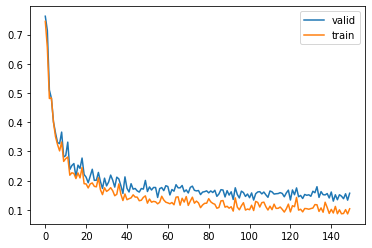

Baseline Test L1 error is 0.7532054781913757
Baseline Test L2 error is 0.25284468539016586
Final model Test L1 error is 0.14186611771583557
Final model Test L2 error is 0.011012321338057518
Best (on validation) model Test L1 error is 0.14215907454490662
Best (on validation) model Test L2 error is 0.0110690388828516


In [80]:
test_dl = DataLoader(SimulationData(simulation_test, charges_test), batch_size=batch_size, shuffle=True, collate_fn=collate)
model_3_1 = model_3_1.eval()

plt.plot(np.arange(0, epochs), result['valid'], label='valid')
plt.plot(np.arange(0, epochs), result['train'], label='train')
plt.legend()
plt.show()

print(f'Baseline Test L1 error is {avg_err(baseline_predict, test_dl)}')
print(f'Baseline Test L2 error is {avg_err(baseline_predict, test_dl, loss_fn=torch.nn.MSELoss(reduction="sum"))}')
print(f'Final model Test L1 error is {avg_err(model_3_1, test_dl)}')
print(f'Final model Test L2 error is {avg_err(model_3_1, test_dl, loss_fn=torch.nn.MSELoss(reduction="sum"))}')

model_best = Model_3_1(hidden_size, n_layers, batch_size)
model_best.load_state_dict(result['best_state'])
model_best = model_best.eval()
print(f'Best (on validation) model Test L1 error is {avg_err(model_best, test_dl)}')
print(f'Best (on validation) model Test L2 error is {avg_err(model_best, test_dl, loss_fn=torch.nn.MSELoss(reduction="sum"))}')

y: tensor([-0.1111, -0.0509, -0.6288]), y_pred: tensor([-0.2112, -0.1030, -0.8619]), loss: 0.1284584105014801


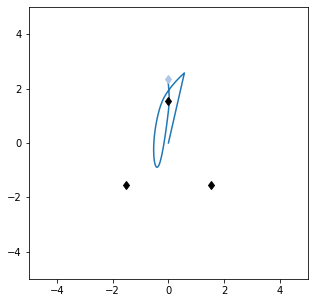

y: tensor([-0.7049, -0.6617, -0.4535]), y_pred: tensor([-0.8456, -0.7604, -0.5425]), loss: 0.10942590236663818


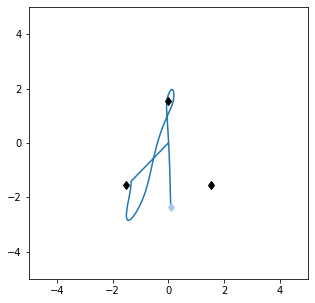

y: tensor([-0.6186, -0.5891, -0.4242]), y_pred: tensor([-0.8132, -0.6513, -0.4792]), loss: 0.10394164174795151


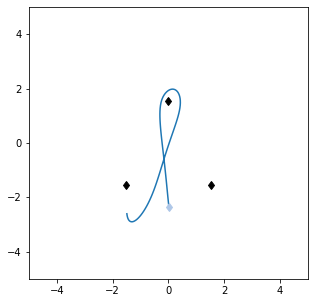

y: tensor([-0.1228, -0.0967, -0.2784]), y_pred: tensor([-0.2140, -0.1897, -0.3987]), loss: 0.10152783989906311


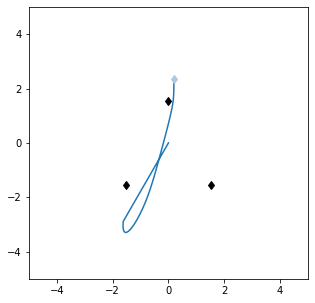

y: tensor([-0.9585, -0.6792, -0.7583]), y_pred: tensor([-0.8596, -0.5540, -0.6886]), loss: 0.09792572259902954


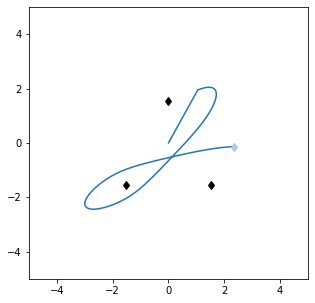

In [109]:
# Check where does the model perform the worst
def topk_err(model, dl, k = 3, loss_fn=torch.nn.L1Loss()):
    '''
    Return the x values with topk worst predictions of model on dl, by given loss function.
    '''
    with torch.no_grad():
        # List of length k stored as (x, y, y_pred, loss), sorted by loss value (max first)
        worst_x = []
        for x, y in dl:
            y_pred = model(x)
            for i in range(x.shape[0]):
                loss = loss_fn(y[i], y_pred[i])
                worst_x.append((x[i], y[i], y_pred[i], loss))
        worst_x = sorted(worst_x, key=lambda p: -p[3])
        return worst_x[:k]

# Plot the worst prediction examples
examples = topk_err(model_best, test_dl, k=5)
for (x, y, y_pred, loss) in examples:
    print(f'y: {y}, y_pred: {y_pred}, loss: {loss}')
    plot_example(x)
# Notes: error seems to be big when the charge magnitude is large, even though % diff is not bad
# also not good when it never approaches one of them

y: tensor([-0.3892, -0.2812, -0.2141]), y_pred: tensor([-0.3800, -0.2789, -0.2096]), loss: 0.016085907816886902


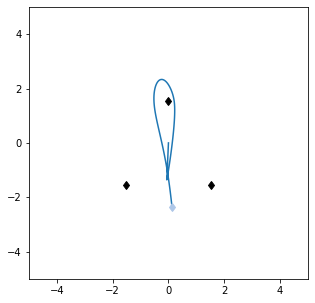

y: tensor([-0.4411, -0.0729, -0.2845]), y_pred: tensor([-0.4321, -0.0764, -0.2907]), loss: 0.018703170120716095


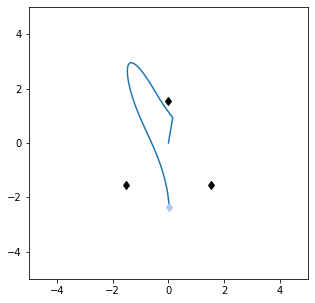

y: tensor([-0.4072, -0.4809, -0.3752]), y_pred: tensor([-0.4191, -0.4863, -0.3798]), loss: 0.021915525197982788


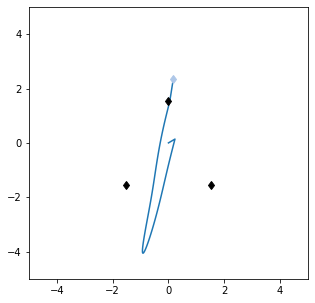

y: tensor([-0.0863, -0.1648, -0.5565]), y_pred: tensor([-0.0958, -0.1872, -0.5572]), loss: 0.03260957449674606


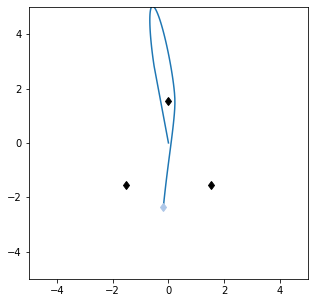

y: tensor([-0.6329, -0.1992, -0.2756]), y_pred: tensor([-0.6519, -0.2069, -0.2840]), loss: 0.035191506147384644


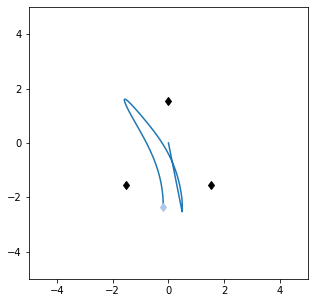

In [82]:
# Now let's see the best ones
examples = topk_err(model_best, test_dl, k=5, loss_fn=lambda y, y_pred: -(y - y_pred).abs().sum())
for (x, y, y_pred, loss) in examples:
    print(f'y: {y}, y_pred: {y_pred}, loss: {-loss}')
    plot_example(x)

# Task 3.2

## Data Handling and Preprocessing

In [83]:
#todo

## Model Implementation

In [84]:
#todo

## Model Training

In [85]:
#todo

## Evaluation

In [86]:
#todo